In [230]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import pinot
import torch
from matplotlib import pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
ds = pinot.data.moonshot_with_date()


In [232]:
ds_0 = ds.filter_by_time(before='2020-05-12')
ds_1 = ds.filter_by_time(before='2020-05-19')
ds_2 = ds.filter_by_time(before='2020-05-26')
ds_3 = ds.filter_by_time(before='2020-06-02')
ds_4 = ds.filter_by_time(before='2020-06-09')
ds_all = ds.filter_by_time(before='2666-12-31')



In [233]:

dates = ['May 12', 'May 19', 'May 26', 'Jun 02', 'Jun 09']



In [234]:
collection = [ds_0, ds_1, ds_2, ds_3, ds_4]



In [235]:
collection = [[(g, y[1][None]) for g, y in ds if ~torch.isnan(y[1])] for ds in collection]


In [236]:
print([len(x) for x in collection])

[19, 41, 58, 60, 60]


In [237]:
collection = [pinot.data.utils.batch(ds, len(ds)) for ds in collection]



In [238]:
ds_all = pinot.data.utils.batch(ds_all, len(ds_all))

In [239]:
g_all, y_all = ds_all[0]

1.1689508
1.1069205
1.0391164
1.0186026


No handles with labels found to put in legend.


1.0284011


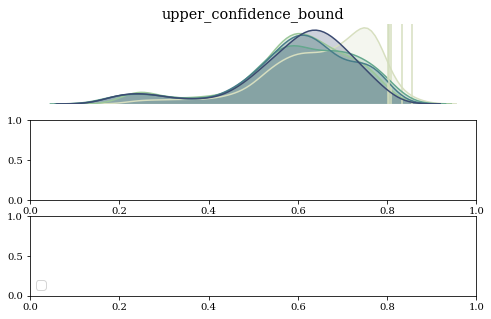

In [242]:
plt.rc('font', family='serif', size=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

sns.set_palette(sns.cubehelix_palette(6, start=.5, rot=-.75))
cmap=sns.cubehelix_palette(6, start=.5, rot=-.75, as_cmap=True)

f, axes = plt.subplots(3, 1, figsize=(8, 5))

# fns = ['probability_of_improvement', 'expected_improvement', 'upper_confidence_bound']

fns = ['upper_confidence_bound']

for fn_idx, fn in enumerate(fns):
    for idx in range(5):
        net = pinot.Net(
            representation=pinot.representation.Sequential(
                layer=pinot.representation.dgl_legacy.gn(),
                config=[32, 'tanh', 32, 'tanh', 32, 'tanh']),
            output_regressor=pinot.regressors.ExactGaussianProcessRegressor)

        optimizer = torch.optim.Adam(net.parameters(), 1e-3)

        data=collection[idx]
        
        g_, y_ = data[0]
        
        y_best = y_.max()
        
        train = pinot.Train(
            net=net,
            data=data,
            n_epochs=10,
            optimizer=optimizer
            )

        net = train.train()

        dist = pinot.metrics._independent(net.condition(ds_all[0][0]))

        score = getattr(pinot.active.acquisition, fn)(dist, y_best=y_best).detach().numpy().flatten()
        
        score_max = np.max(score)
        
        print(score_max - y_best.detach().numpy())
        
        axes[fn_idx].axvline(x=score_max, c=cmap(idx))

        g = sns.kdeplot(score, shade=True, label=dates[idx], ax=axes[fn_idx])
        
        axes[fn_idx].axis('off')
        
        g.legend().remove()
        
        axes[fn_idx].set_title(fns[fn_idx])
        
        
plt.legend(loc='lower left')





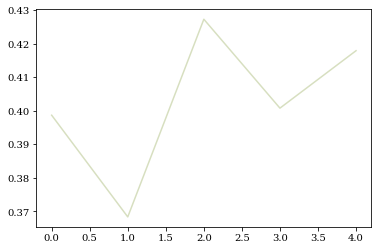

In [229]:
plt.plot([0.3986796,
0.36837095,
0.42728257,
0.40078926,
0.41790712])

In [99]:
dist = pinot.metrics._independent(net.condition(ds_all[0][0]))


In [225]:
ds_0 = ds.filter_by_time(after='1989-06-04', before='2020-05-12')
ds_1 = ds.filter_by_time(after='2020-05-13', before='2020-05-19')
ds_2 = ds.filter_by_time(after='2020-05-20', before='2020-05-26')
ds_3 = ds.filter_by_time(after='2020-05-27', before='2020-06-02')
ds_4 = ds.filter_by_time(after='2020-06-03', before='2020-06-09')
ds_all = ds.filter_by_time(before='2666-12-31')


In [226]:
print(len(ds_0), len(ds_1), len(ds_2), len(ds_3))

265 92 120 56


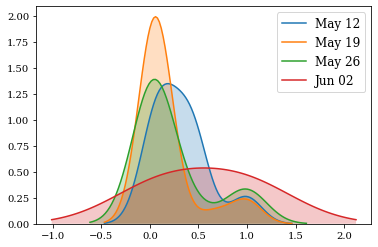

In [190]:
sns.set_palette('tab10')
for idx, ds in enumerate(collection):
    g, y = ds[0]
    sns.kdeplot(y.flatten().detach().numpy(), shade=True, label=dates[idx])
    
    